In [1]:
import os
import json
import numpy as np
import librosa
import pywt  # 用于连续小波变换 (CWT)
import cv2   # 用于图像处理和保存
import matplotlib.pyplot as plt
# 如果需要进行模型推理和Grad-CAM
import torch
import torch.nn as nn
import torch.nn.functional as F

# 配置路径和参数
base_dir = "./Voice/KCL_Text_HC"  # 数据集根目录，需要根据实际路径修改
output_suffix = "_Output"    # 输出文件夹的后缀
target_sr = 16000            # 重采样目标采样率

# 遍历数据集目录，收集所有非Output子目录下的wav文件路径
wav_files = []
for root, dirs, files in os.walk(base_dir):
    # 跳过Output文件夹
    if output_suffix.lower() in root.lower():
        continue
    for fname in files:
        if fname.lower().endswith(".wav"):
            full_path = os.path.join(root, fname)
            wav_files.append(full_path)

print(f"共找到 {len(wav_files)} 个音频文件待处理。")

# 确保每个对应的 Output 文件夹存在
for root, dirs, files in os.walk(base_dir):
    for d in dirs:
        if d.endswith(output_suffix):
            out_dir = os.path.join(root, d)
            os.makedirs(out_dir, exist_ok=True)


共找到 527 个音频文件待处理。


In [2]:
# 辅助函数：计算并返回 CQT dB 频谱矩阵和频率轴
def compute_cqt_spectrogram(y, sr, bins_per_octave=84):
    # 使用 librosa 计算常数Q变换 (CQT)
    C = librosa.cqt(y, sr=sr, hop_length=512, fmin=librosa.note_to_hz('C1'),
                    n_bins=bins_per_octave, bins_per_octave=12)
    C_mag = np.abs(C)  # 取幅值
    # 转换为对数刻度 (dB)
    C_db = librosa.amplitude_to_db(C_mag, ref=np.max, top_db=80)
    # 获取频率轴范围（使用 librosa 提供的工具）
    freqs = librosa.cqt_frequencies(C_db.shape[0], fmin=librosa.note_to_hz('C1'), bins_per_octave=12)
    return C_db, freqs

# 辅助函数：计算并返回 Scalogram (CWT) dB 频谱矩阵和频率轴
def compute_cwt_scalogram(y, sr, wavelet='morl', num_scales=128):
    # 定义尺度序列（从1到num_scales）
    scales = np.arange(1, num_scales + 1)
    # 计算连续小波变换 (CWT)
    coefficients, frequencies = pywt.cwt(y, scales, wavelet, sampling_period=1.0/sr)
    # CWT 返回的 coefficients shape: (num_scales, signal_length)
    # 取绝对值
    cwt_mag = np.abs(coefficients)
    # 转换为对数刻度 (dB)，参考最大值
    cwt_db = librosa.amplitude_to_db(cwt_mag, ref=np.max, top_db=80)
    # 频率轴已由 PyWavelets 返回（降序），将其翻转为升序以对应矩阵行顺序
    freqs = frequencies[::-1]  # frequencies 与 scales 一一对应（从高频到低频），翻转为从低频到高频
    cwt_db = cwt_db[::-1]      # 相应地翻转系数矩阵，使得 [0,0] 对应最低频率
    return cwt_db, freqs

# 辅助函数：将频谱dB矩阵映射为彩色图像并保存
def save_spectrogram_image(db_matrix, cmap, save_path):
    """
    将给定的dB频谱矩阵映射为0-255并保存为彩色PNG图像。
    cmap 参数为 OpenCV 的颜色映射，例如 cv2.COLORMAP_VIRIDIS。
    """
    # 将dB值从[-X, 0]归一化到[0, 255]
    db_min = db_matrix.min()
    db_max = db_matrix.max()
    norm_matrix = (db_matrix - db_min) / (db_max - db_min + 1e-6)  # [0, 1]
    img_gray = (norm_matrix * 255).astype(np.uint8)
    # 应用伪彩色
    img_color = cv2.applyColorMap(img_gray, cmap)
    # 将BGR格式转换为RGB再保存
    img_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
    cv2.imwrite(save_path, img_rgb)


In [3]:
# 选择颜色映射 (OpenCV 常量)，这里使用 VIRIDIS，可根据需要更改为 INFERNO 等
cmap = cv2.COLORMAP_VIRIDIS

# 处理每个音频文件
for wav_path in wav_files:
    # 加载音频并重采样到 target_sr
    y, sr = librosa.load(wav_path, sr=target_sr)
    duration = len(y) / sr  # 音频时长（秒）

    # 生成 CQT 频谱和 Scalogram
    cqt_db, cqt_freqs = compute_cqt_spectrogram(y, sr)
    cwt_db, cwt_freqs = compute_cwt_scalogram(y, sr)

    # 构建输出文件路径
    # 输出目录：用当前音频路径中找到的对应 *_Output 目录
    # 例如 input: "China_HC/abc.wav" -> output_dir: "China_Output"
    dir_path, file_name = os.path.split(wav_path)
    # 找到同级目录下的 *Output 目录
    parent_dir = os.path.dirname(dir_path)
    base_folder = os.path.basename(dir_path)
    output_folder = base_folder.split(os.sep)[0] + output_suffix if not base_folder.endswith(output_suffix) else base_folder
    output_dir = os.path.join(parent_dir, output_folder)
    os.makedirs(output_dir, exist_ok=True)
    name_base, _ = os.path.splitext(file_name)
    # 确保文件名唯一：可以加上父文件夹名称前缀
    output_prefix = name_base
    if base_folder not in output_folder:
        output_prefix = f"{base_folder}_{name_base}"

    cqt_img_path = os.path.join(output_dir, f"{output_prefix}_cqt.png")
    cwt_img_path = os.path.join(output_dir, f"{output_prefix}_cwt.png")
    json_path    = os.path.join(output_dir, f"{output_prefix}_spec.json")

    # 保存频谱图彩色图像
    save_spectrogram_image(cqt_db, cmap, cqt_img_path)
    save_spectrogram_image(cwt_db, cmap, cwt_img_path)

    # 准备元数据 JSON（时间轴和频率轴范围、分辨率等）
    data = {
        "audio_path": wav_path,
        "duration_sec": duration,
        "sr": sr,
        "cqt": {
            "freq_min": float(cqt_freqs.min()) if cqt_freqs.size > 0 else 0.0,
            "freq_max": float(cqt_freqs.max()) if cqt_freqs.size > 0 else float(sr/2),
            "n_bins": int(cqt_db.shape[0]),
            "time_bins": int(cqt_db.shape[1]),
            "time_resolution_sec": 512 / sr  # hop_length / sr
        },
        "cwt": {
            "freq_min": float(cwt_freqs.min()) if cwt_freqs.size > 0 else 0.0,
            "freq_max": float(cwt_freqs.max()) if cwt_freqs.size > 0 else float(sr/2),
            "scales": int(cwt_db.shape[0]),
            "time_samples": int(cwt_db.shape[1]),
            "time_resolution_sec": 1.0/sr   # CWT输出时间步近似为采样点间隔
        }
    }
    # 保存 JSON 信息
    with open(json_path, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

    print(f"Processed {wav_path} -> {cqt_img_path}, {cwt_img_path}")


Processed ./Voice/KCL_Text_HC/ID25_hc_0_0_0_chunk132.wav -> ./Voice/KCL_Text_HC_Output/ID25_hc_0_0_0_chunk132_cqt.png, ./Voice/KCL_Text_HC_Output/ID25_hc_0_0_0_chunk132_cwt.png
Processed ./Voice/KCL_Text_HC/ID25_hc_0_0_0_chunk126.wav -> ./Voice/KCL_Text_HC_Output/ID25_hc_0_0_0_chunk126_cqt.png, ./Voice/KCL_Text_HC_Output/ID25_hc_0_0_0_chunk126_cwt.png
Processed ./Voice/KCL_Text_HC/ID31_hc_0_1_1_chunk0.wav -> ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk0_cqt.png, ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk0_cwt.png
Processed ./Voice/KCL_Text_HC/ID28_hc_0_0_0_chunk138.wav -> ./Voice/KCL_Text_HC_Output/ID28_hc_0_0_0_chunk138_cqt.png, ./Voice/KCL_Text_HC_Output/ID28_hc_0_0_0_chunk138_cwt.png
Processed ./Voice/KCL_Text_HC/ID11_hc_0_0_0_chunk6.wav -> ./Voice/KCL_Text_HC_Output/ID11_hc_0_0_0_chunk6_cqt.png, ./Voice/KCL_Text_HC_Output/ID11_hc_0_0_0_chunk6_cwt.png
Processed ./Voice/KCL_Text_HC/ID10_hc_0_0_0_chunk102.wav -> ./Voice/KCL_Text_HC_Output/ID10_hc_0_0_0_chunk102_cqt.png, ./Voice/

libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID01_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_cwt.png
Processed ./Voice/KCL_Text_HC/ID31_hc_0_1_1_chunk12.wav -> ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk12_cqt.png, ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk12_cwt.png
Processed ./Voice/KCL_Text_HC/ID10_hc_0_0_0_chunk6.wav -> ./Voice/KCL_Text_HC_Output/ID10_hc_0_0_0_chunk6_cqt.png, ./Voice/KCL_Text_HC_Output/ID10_hc_0_0_0_chunk6_cwt.png
Processed ./Voice/KCL_Text_HC/ID00_hc_0_0_0_chunk54.wav -> ./Voice/KCL_Text_HC_Output/ID00_hc_0_0_0_chunk54_cqt.png, ./Voice/KCL_Text_HC_Output/ID00_hc_0_0_0_chunk54_cwt.png
Processed ./Voice/KCL_Text_HC/ID23_hc_0_0_0_chunk168.wav -> ./Voice/KCL_Text_HC_Output/ID23_hc_0_0_0_chunk168_cqt.png, ./Voice/KCL_Text_HC_Output/ID23_hc_0_0_0_chunk168_cwt.png
Processed ./Voice/KCL_Text_HC/ID36_hc_0_0_0_chunk36.wav -> ./Voice/KCL_Text_HC_Output/ID36_hc_0_0_0_chunk36_cqt.png, ./Voice/KCL_Text_HC_Output/ID36_hc_0_

libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID14_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID14_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID14_hc_0_0_0_cwt.png
Processed ./Voice/KCL_Text_HC/ID05_hc_0_0_0_chunk96.wav -> ./Voice/KCL_Text_HC_Output/ID05_hc_0_0_0_chunk96_cqt.png, ./Voice/KCL_Text_HC_Output/ID05_hc_0_0_0_chunk96_cwt.png
Processed ./Voice/KCL_Text_HC/ID12_hc_0_0_0_chunk78.wav -> ./Voice/KCL_Text_HC_Output/ID12_hc_0_0_0_chunk78_cqt.png, ./Voice/KCL_Text_HC_Output/ID12_hc_0_0_0_chunk78_cwt.png
Processed ./Voice/KCL_Text_HC/ID36_hc_0_0_0_chunk138.wav -> ./Voice/KCL_Text_HC_Output/ID36_hc_0_0_0_chunk138_cqt.png, ./Voice/KCL_Text_HC_Output/ID36_hc_0_0_0_chunk138_cwt.png
Processed ./Voice/KCL_Text_HC/ID03_hc_0_0_0_chunk120.wav -> ./Voice/KCL_Text_HC_Output/ID03_hc_0_0_0_chunk120_cqt.png, ./Voice/KCL_Text_HC_Output/ID03_hc_0_0_0_chunk120_cwt.png
Processed ./Voice/KCL_Text_HC/ID03_hc_0_0_0_chunk108.wav -> ./Voice/KCL_Text_HC_Output/ID03_hc_0_0_0_chunk108_cqt.png, ./Voice/KCL_Text_HC_Output/ID

libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID25_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID25_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID25_hc_0_0_0_cwt.png
Processed ./Voice/KCL_Text_HC/ID23_hc_0_0_0_chunk48.wav -> ./Voice/KCL_Text_HC_Output/ID23_hc_0_0_0_chunk48_cqt.png, ./Voice/KCL_Text_HC_Output/ID23_hc_0_0_0_chunk48_cwt.png
Processed ./Voice/KCL_Text_HC/ID15_hc_0_0_0_chunk108.wav -> ./Voice/KCL_Text_HC_Output/ID15_hc_0_0_0_chunk108_cqt.png, ./Voice/KCL_Text_HC_Output/ID15_hc_0_0_0_chunk108_cwt.png
Processed ./Voice/KCL_Text_HC/ID15_hc_0_0_0_chunk120.wav -> ./Voice/KCL_Text_HC_Output/ID15_hc_0_0_0_chunk120_cqt.png, ./Voice/KCL_Text_HC_Output/ID15_hc_0_0_0_chunk120_cwt.png


libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID22_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID22_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID22_hc_0_0_0_cwt.png
Processed ./Voice/KCL_Text_HC/ID25_hc_0_0_0_chunk78.wav -> ./Voice/KCL_Text_HC_Output/ID25_hc_0_0_0_chunk78_cqt.png, ./Voice/KCL_Text_HC_Output/ID25_hc_0_0_0_chunk78_cwt.png
Processed ./Voice/KCL_Text_HC/ID01_hc_0_0_0_chunk126.wav -> ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk126_cqt.png, ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk126_cwt.png
Processed ./Voice/KCL_Text_HC/ID01_hc_0_0_0_chunk132.wav -> ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk132_cqt.png, ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk132_cwt.png
Processed ./Voice/KCL_Text_HC/ID21_hc_0_0_0_chunk18.wav -> ./Voice/KCL_Text_HC_Output/ID21_hc_0_0_0_chunk18_cqt.png, ./Voice/KCL_Text_HC_Output/ID21_hc_0_0_0_chunk18_cwt.png
Processed ./Voice/KCL_Text_HC/ID21_hc_0_0_0_chunk24.wav -> ./Voice/KCL_Text_HC_Output/ID21_hc_0_0_0_chunk24_cqt.png, ./Voice/KCL_Text_HC_Output/ID21

libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID12_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID12_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID12_hc_0_0_0_cwt.png
Processed ./Voice/KCL_Text_HC/ID00_hc_0_0_0_chunk90.wav -> ./Voice/KCL_Text_HC_Output/ID00_hc_0_0_0_chunk90_cqt.png, ./Voice/KCL_Text_HC_Output/ID00_hc_0_0_0_chunk90_cwt.png
Processed ./Voice/KCL_Text_HC/ID28_hc_0_0_0_chunk12.wav -> ./Voice/KCL_Text_HC_Output/ID28_hc_0_0_0_chunk12_cqt.png, ./Voice/KCL_Text_HC_Output/ID28_hc_0_0_0_chunk12_cwt.png


libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID15_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID15_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID15_hc_0_0_0_cwt.png
Processed ./Voice/KCL_Text_HC/ID08_hc_0_0_0_chunk0.wav -> ./Voice/KCL_Text_HC_Output/ID08_hc_0_0_0_chunk0_cqt.png, ./Voice/KCL_Text_HC_Output/ID08_hc_0_0_0_chunk0_cwt.png
Processed ./Voice/KCL_Text_HC/ID11_hc_0_0_0_chunk72.wav -> ./Voice/KCL_Text_HC_Output/ID11_hc_0_0_0_chunk72_cqt.png, ./Voice/KCL_Text_HC_Output/ID11_hc_0_0_0_chunk72_cwt.png
Processed ./Voice/KCL_Text_HC/ID11_hc_0_0_0_chunk66.wav -> ./Voice/KCL_Text_HC_Output/ID11_hc_0_0_0_chunk66_cqt.png, ./Voice/KCL_Text_HC_Output/ID11_hc_0_0_0_chunk66_cwt.png
Processed ./Voice/KCL_Text_HC/ID25_hc_0_0_0_chunk96.wav -> ./Voice/KCL_Text_HC_Output/ID25_hc_0_0_0_chunk96_cqt.png, ./Voice/KCL_Text_HC_Output/ID25_hc_0_0_0_chunk96_cwt.png
Processed ./Voice/KCL_Text_HC/ID25_hc_0_0_0_chunk54.wav -> ./Voice/KCL_Text_HC_Output/ID25_hc_0_0_0_chunk54_cqt.png, ./Voice/KCL_Text_HC_Output/ID25_hc_0_0_0

libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID00_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID00_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID00_hc_0_0_0_cwt.png
Processed ./Voice/KCL_Text_HC/ID09_hc_0_0_0_chunk0.wav -> ./Voice/KCL_Text_HC_Output/ID09_hc_0_0_0_chunk0_cqt.png, ./Voice/KCL_Text_HC_Output/ID09_hc_0_0_0_chunk0_cwt.png
Processed ./Voice/KCL_Text_HC/ID12_hc_0_0_0_chunk42.wav -> ./Voice/KCL_Text_HC_Output/ID12_hc_0_0_0_chunk42_cqt.png, ./Voice/KCL_Text_HC_Output/ID12_hc_0_0_0_chunk42_cwt.png
Processed ./Voice/KCL_Text_HC/ID09_hc_0_0_0_chunk108.wav -> ./Voice/KCL_Text_HC_Output/ID09_hc_0_0_0_chunk108_cqt.png, ./Voice/KCL_Text_HC_Output/ID09_hc_0_0_0_chunk108_cwt.png
Processed ./Voice/KCL_Text_HC/ID05_hc_0_0_0_chunk90.wav -> ./Voice/KCL_Text_HC_Output/ID05_hc_0_0_0_chunk90_cqt.png, ./Voice/KCL_Text_HC_Output/ID05_hc_0_0_0_chunk90_cwt.png
Processed ./Voice/KCL_Text_HC/ID09_hc_0_0_0_chunk120.wav -> ./Voice/KCL_Text_HC_Output/ID09_hc_0_0_0_chunk120_cqt.png, ./Voice/KCL_Text_HC_Output/ID09_hc_

libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID36_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID36_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID36_hc_0_0_0_cwt.png
Processed ./Voice/KCL_Text_HC/ID25_hc_0_0_0_chunk42.wav -> ./Voice/KCL_Text_HC_Output/ID25_hc_0_0_0_chunk42_cqt.png, ./Voice/KCL_Text_HC_Output/ID25_hc_0_0_0_chunk42_cwt.png
Processed ./Voice/KCL_Text_HC/ID01_hc_0_0_0_chunk108.wav -> ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk108_cqt.png, ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk108_cwt.png
Processed ./Voice/KCL_Text_HC/ID01_hc_0_0_0_chunk120.wav -> ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk120_cqt.png, ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk120_cwt.png
Processed ./Voice/KCL_Text_HC/ID23_hc_0_0_0_chunk186.wav -> ./Voice/KCL_Text_HC_Output/ID23_hc_0_0_0_chunk186_cqt.png, ./Voice/KCL_Text_HC_Output/ID23_hc_0_0_0_chunk186_cwt.png
Processed ./Voice/KCL_Text_HC/ID21_hc_0_0_0_chunk36.wav -> ./Voice/KCL_Text_HC_Output/ID21_hc_0_0_0_chunk36_cqt.png, ./Voice/KCL_Text_HC_Output/I

libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID23_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID23_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID23_hc_0_0_0_cwt.png
Processed ./Voice/KCL_Text_HC/ID31_hc_0_1_1_chunk132.wav -> ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk132_cqt.png, ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk132_cwt.png
Processed ./Voice/KCL_Text_HC/ID22_hc_0_0_0_chunk138.wav -> ./Voice/KCL_Text_HC_Output/ID22_hc_0_0_0_chunk138_cqt.png, ./Voice/KCL_Text_HC_Output/ID22_hc_0_0_0_chunk138_cwt.png
Processed ./Voice/KCL_Text_HC/ID05_hc_0_0_0_chunk78.wav -> ./Voice/KCL_Text_HC_Output/ID05_hc_0_0_0_chunk78_cqt.png, ./Voice/KCL_Text_HC_Output/ID05_hc_0_0_0_chunk78_cwt.png
Processed ./Voice/KCL_Text_HC/ID26_hc_0_0_0_chunk66.wav -> ./Voice/KCL_Text_HC_Output/ID26_hc_0_0_0_chunk66_cqt.png, ./Voice/KCL_Text_HC_Output/ID26_hc_0_0_0_chunk66_cwt.png
Processed ./Voice/KCL_Text_HC/ID12_hc_0_0_0_chunk96.wav -> ./Voice/KCL_Text_HC_Output/ID12_hc_0_0_0_chunk96_cqt.png, ./Voice/KCL_Text_HC_Output/ID12

Processed ./Voice/KCL_Text_HC/ID15_hc_0_0_0_chunk156.wav -> ./Voice/KCL_Text_HC_Output/ID15_hc_0_0_0_chunk156_cqt.png, ./Voice/KCL_Text_HC_Output/ID15_hc_0_0_0_chunk156_cwt.png
Processed ./Voice/KCL_Text_HC/ID15_hc_0_0_0_chunk48.wav -> ./Voice/KCL_Text_HC_Output/ID15_hc_0_0_0_chunk48_cqt.png, ./Voice/KCL_Text_HC_Output/ID15_hc_0_0_0_chunk48_cwt.png
Processed ./Voice/KCL_Text_HC/ID23_hc_0_0_0_chunk108.wav -> ./Voice/KCL_Text_HC_Output/ID23_hc_0_0_0_chunk108_cqt.png, ./Voice/KCL_Text_HC_Output/ID23_hc_0_0_0_chunk108_cwt.png
Processed ./Voice/KCL_Text_HC/ID19_hc_0_0_0_chunk6.wav -> ./Voice/KCL_Text_HC_Output/ID19_hc_0_0_0_chunk6_cqt.png, ./Voice/KCL_Text_HC_Output/ID19_hc_0_0_0_chunk6_cwt.png
Processed ./Voice/KCL_Text_HC/ID31_hc_0_1_1_chunk66.wav -> ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk66_cqt.png, ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk66_cwt.png
Processed ./Voice/KCL_Text_HC/ID31_hc_0_1_1_chunk72.wav -> ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk72_cqt.png, ./Voice/KC

libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID28_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID28_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID28_hc_0_0_0_cwt.png


libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID31_hc_0_1_1.wav -> ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_cqt.png, ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_cwt.png
Processed ./Voice/KCL_Text_HC/ID26_hc_0_0_0_chunk138.wav -> ./Voice/KCL_Text_HC_Output/ID26_hc_0_0_0_chunk138_cqt.png, ./Voice/KCL_Text_HC_Output/ID26_hc_0_0_0_chunk138_cwt.png
Processed ./Voice/KCL_Text_HC/ID26_hc_0_0_0_chunk12.wav -> ./Voice/KCL_Text_HC_Output/ID26_hc_0_0_0_chunk12_cqt.png, ./Voice/KCL_Text_HC_Output/ID26_hc_0_0_0_chunk12_cwt.png
Processed ./Voice/KCL_Text_HC/ID05_hc_0_0_0_chunk18.wav -> ./Voice/KCL_Text_HC_Output/ID05_hc_0_0_0_chunk18_cqt.png, ./Voice/KCL_Text_HC_Output/ID05_hc_0_0_0_chunk18_cwt.png
Processed ./Voice/KCL_Text_HC/ID05_hc_0_0_0_chunk30.wav -> ./Voice/KCL_Text_HC_Output/ID05_hc_0_0_0_chunk30_cqt.png, ./Voice/KCL_Text_HC_Output/ID05_hc_0_0_0_chunk30_cwt.png
Processed ./Voice/KCL_Text_HC/ID05_hc_0_0_0_chunk24.wav -> ./Voice/KCL_Text_HC_Output/ID05_hc_0_0_0_chunk24_cqt.png, ./Voice/KCL_Text_HC_Output/ID05_hc

libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID19_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID19_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID19_hc_0_0_0_cwt.png
Processed ./Voice/KCL_Text_HC/ID21_hc_0_0_0_chunk54.wav -> ./Voice/KCL_Text_HC_Output/ID21_hc_0_0_0_chunk54_cqt.png, ./Voice/KCL_Text_HC_Output/ID21_hc_0_0_0_chunk54_cwt.png
Processed ./Voice/KCL_Text_HC/ID08_hc_0_0_0_chunk114.wav -> ./Voice/KCL_Text_HC_Output/ID08_hc_0_0_0_chunk114_cqt.png, ./Voice/KCL_Text_HC_Output/ID08_hc_0_0_0_chunk114_cwt.png
Processed ./Voice/KCL_Text_HC/ID28_hc_0_0_0_chunk72.wav -> ./Voice/KCL_Text_HC_Output/ID28_hc_0_0_0_chunk72_cqt.png, ./Voice/KCL_Text_HC_Output/ID28_hc_0_0_0_chunk72_cwt.png
Processed ./Voice/KCL_Text_HC/ID28_hc_0_0_0_chunk66.wav -> ./Voice/KCL_Text_HC_Output/ID28_hc_0_0_0_chunk66_cqt.png, ./Voice/KCL_Text_HC_Output/ID28_hc_0_0_0_chunk66_cwt.png
Processed ./Voice/KCL_Text_HC/ID01_hc_0_0_0_chunk0.wav -> ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk0_cqt.png, ./Voice/KCL_Text_HC_Output/ID01_hc_0

/Users/beibeiliu/anaconda3/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=256 is too large for input signal of length=244
  warnings.warn(


Processed ./Voice/KCL_Text_HC/ID31_hc_0_1_1_chunk192.wav -> ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk192_cqt.png, ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk192_cwt.png
Processed ./Voice/KCL_Text_HC/ID31_hc_0_1_1_chunk186.wav -> ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk186_cqt.png, ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk186_cwt.png
Processed ./Voice/KCL_Text_HC/ID10_hc_0_0_0_chunk42.wav -> ./Voice/KCL_Text_HC_Output/ID10_hc_0_0_0_chunk42_cqt.png, ./Voice/KCL_Text_HC_Output/ID10_hc_0_0_0_chunk42_cwt.png
Processed ./Voice/KCL_Text_HC/ID31_hc_0_1_1_chunk174.wav -> ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk174_cqt.png, ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk174_cwt.png
Processed ./Voice/KCL_Text_HC/ID22_hc_0_0_0_chunk156.wav -> ./Voice/KCL_Text_HC_Output/ID22_hc_0_0_0_chunk156_cqt.png, ./Voice/KCL_Text_HC_Output/ID22_hc_0_0_0_chunk156_cwt.png
Processed ./Voice/KCL_Text_HC/ID35_hc_0_0_0_chunk6.wav -> ./Voice/KCL_Text_HC_Output/ID35_hc_0_0_0_chunk6_cqt.png, ./V

libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID09_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID09_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID09_hc_0_0_0_cwt.png
Processed ./Voice/KCL_Text_HC/ID28_hc_0_0_0_chunk54.wav -> ./Voice/KCL_Text_HC_Output/ID28_hc_0_0_0_chunk54_cqt.png, ./Voice/KCL_Text_HC_Output/ID28_hc_0_0_0_chunk54_cwt.png
Processed ./Voice/KCL_Text_HC/ID31_hc_0_1_1_chunk84.wav -> ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk84_cqt.png, ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk84_cwt.png
Processed ./Voice/KCL_Text_HC/ID31_hc_0_1_1_chunk90.wav -> ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk90_cqt.png, ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk90_cwt.png
Processed ./Voice/KCL_Text_HC/ID15_hc_0_0_0_chunk96.wav -> ./Voice/KCL_Text_HC_Output/ID15_hc_0_0_0_chunk96_cqt.png, ./Voice/KCL_Text_HC_Output/ID15_hc_0_0_0_chunk96_cwt.png
Processed ./Voice/KCL_Text_HC/ID08_hc_0_0_0_chunk126.wav -> ./Voice/KCL_Text_HC_Output/ID08_hc_0_0_0_chunk126_cqt.png, ./Voice/KCL_Text_HC_Output/ID08_hc_

Processed ./Voice/KCL_Text_HC/ID36_hc_0_0_0_chunk156.wav -> ./Voice/KCL_Text_HC_Output/ID36_hc_0_0_0_chunk156_cqt.png, ./Voice/KCL_Text_HC_Output/ID36_hc_0_0_0_chunk156_cwt.png
Processed ./Voice/KCL_Text_HC/ID10_hc_0_0_0_chunk90.wav -> ./Voice/KCL_Text_HC_Output/ID10_hc_0_0_0_chunk90_cqt.png, ./Voice/KCL_Text_HC_Output/ID10_hc_0_0_0_chunk90_cwt.png
Processed ./Voice/KCL_Text_HC/ID10_hc_0_0_0_chunk84.wav -> ./Voice/KCL_Text_HC_Output/ID10_hc_0_0_0_chunk84_cqt.png, ./Voice/KCL_Text_HC_Output/ID10_hc_0_0_0_chunk84_cwt.png


libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID08_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID08_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID08_hc_0_0_0_cwt.png
Processed ./Voice/KCL_Text_HC/ID01_hc_0_0_0_chunk66.wav -> ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk66_cqt.png, ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk66_cwt.png
Processed ./Voice/KCL_Text_HC/ID22_hc_0_0_0_chunk78.wav -> ./Voice/KCL_Text_HC_Output/ID22_hc_0_0_0_chunk78_cqt.png, ./Voice/KCL_Text_HC_Output/ID22_hc_0_0_0_chunk78_cwt.png
Processed ./Voice/KCL_Text_HC/ID01_hc_0_0_0_chunk72.wav -> ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk72_cqt.png, ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk72_cwt.png
Processed ./Voice/KCL_Text_HC/ID08_hc_0_0_0_chunk54.wav -> ./Voice/KCL_Text_HC_Output/ID08_hc_0_0_0_chunk54_cqt.png, ./Voice/KCL_Text_HC_Output/ID08_hc_0_0_0_chunk54_cwt.png
Processed ./Voice/KCL_Text_HC/ID28_hc_0_0_0_chunk90.wav -> ./Voice/KCL_Text_HC_Output/ID28_hc_0_0_0_chunk90_cqt.png, ./Voice/KCL_Text_HC_Output/ID28_hc_0_

/Users/beibeiliu/anaconda3/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=256 is too large for input signal of length=174
  warnings.warn(
/Users/beibeiliu/anaconda3/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=256 is too large for input signal of length=87
  warnings.warn(


Processed ./Voice/KCL_Text_HC/ID36_hc_0_0_0_chunk0.wav -> ./Voice/KCL_Text_HC_Output/ID36_hc_0_0_0_chunk0_cqt.png, ./Voice/KCL_Text_HC_Output/ID36_hc_0_0_0_chunk0_cwt.png
Processed ./Voice/KCL_Text_HC/ID36_hc_0_0_0_chunk126.wav -> ./Voice/KCL_Text_HC_Output/ID36_hc_0_0_0_chunk126_cqt.png, ./Voice/KCL_Text_HC_Output/ID36_hc_0_0_0_chunk126_cwt.png
Processed ./Voice/KCL_Text_HC/ID36_hc_0_0_0_chunk132.wav -> ./Voice/KCL_Text_HC_Output/ID36_hc_0_0_0_chunk132_cqt.png, ./Voice/KCL_Text_HC_Output/ID36_hc_0_0_0_chunk132_cwt.png
Processed ./Voice/KCL_Text_HC/ID03_hc_0_0_0_chunk102.wav -> ./Voice/KCL_Text_HC_Output/ID03_hc_0_0_0_chunk102_cqt.png, ./Voice/KCL_Text_HC_Output/ID03_hc_0_0_0_chunk102_cwt.png
Processed ./Voice/KCL_Text_HC/ID22_hc_0_0_0_chunk36.wav -> ./Voice/KCL_Text_HC_Output/ID22_hc_0_0_0_chunk36_cqt.png, ./Voice/KCL_Text_HC_Output/ID22_hc_0_0_0_chunk36_cwt.png


libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID10_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID10_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID10_hc_0_0_0_cwt.png
Processed ./Voice/KCL_Text_HC/ID00_hc_0_0_0_chunk144.wav -> ./Voice/KCL_Text_HC_Output/ID00_hc_0_0_0_chunk144_cqt.png, ./Voice/KCL_Text_HC_Output/ID00_hc_0_0_0_chunk144_cwt.png
Processed ./Voice/KCL_Text_HC/ID00_hc_0_0_0_chunk150.wav -> ./Voice/KCL_Text_HC_Output/ID00_hc_0_0_0_chunk150_cqt.png, ./Voice/KCL_Text_HC_Output/ID00_hc_0_0_0_chunk150_cwt.png
Processed ./Voice/KCL_Text_HC/ID23_hc_0_0_0_chunk174.wav -> ./Voice/KCL_Text_HC_Output/ID23_hc_0_0_0_chunk174_cqt.png, ./Voice/KCL_Text_HC_Output/ID23_hc_0_0_0_chunk174_cwt.png
Processed ./Voice/KCL_Text_HC/ID00_hc_0_0_0_chunk48.wav -> ./Voice/KCL_Text_HC_Output/ID00_hc_0_0_0_chunk48_cqt.png, ./Voice/KCL_Text_HC_Output/ID00_hc_0_0_0_chunk48_cwt.png
Processed ./Voice/KCL_Text_HC/ID22_hc_0_0_0_chunk0.wav -> ./Voice/KCL_Text_HC_Output/ID22_hc_0_0_0_chunk0_cqt.png, ./Voice/KCL_Text_HC_Output/ID2

libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID05_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID05_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID05_hc_0_0_0_cwt.png
Processed ./Voice/KCL_Text_HC/ID01_hc_0_0_0_chunk138.wav -> ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk138_cqt.png, ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk138_cwt.png
Processed ./Voice/KCL_Text_HC/ID11_hc_0_0_0_chunk54.wav -> ./Voice/KCL_Text_HC_Output/ID11_hc_0_0_0_chunk54_cqt.png, ./Voice/KCL_Text_HC_Output/ID11_hc_0_0_0_chunk54_cwt.png
Processed ./Voice/KCL_Text_HC/ID09_hc_0_0_0_chunk90.wav -> ./Voice/KCL_Text_HC_Output/ID09_hc_0_0_0_chunk90_cqt.png, ./Voice/KCL_Text_HC_Output/ID09_hc_0_0_0_chunk90_cwt.png
Processed ./Voice/KCL_Text_HC/ID09_hc_0_0_0_chunk84.wav -> ./Voice/KCL_Text_HC_Output/ID09_hc_0_0_0_chunk84_cqt.png, ./Voice/KCL_Text_HC_Output/ID09_hc_0_0_0_chunk84_cwt.png
Processed ./Voice/KCL_Text_HC/ID21_hc_0_0_0_chunk12.wav -> ./Voice/KCL_Text_HC_Output/ID21_hc_0_0_0_chunk12_cqt.png, ./Voice/KCL_Text_HC_Output/ID21_hc

libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID26_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID26_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID26_hc_0_0_0_cwt.png
Processed ./Voice/KCL_Text_HC/ID31_hc_0_1_1_chunk24.wav -> ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk24_cqt.png, ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk24_cwt.png
Processed ./Voice/KCL_Text_HC/ID31_hc_0_1_1_chunk30.wav -> ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk30_cqt.png, ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk30_cwt.png
Processed ./Voice/KCL_Text_HC/ID31_hc_0_1_1_chunk18.wav -> ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk18_cqt.png, ./Voice/KCL_Text_HC_Output/ID31_hc_0_1_1_chunk18_cwt.png
Processed ./Voice/KCL_Text_HC/ID15_hc_0_0_0_chunk36.wav -> ./Voice/KCL_Text_HC_Output/ID15_hc_0_0_0_chunk36_cqt.png, ./Voice/KCL_Text_HC_Output/ID15_hc_0_0_0_chunk36_cwt.png
Processed ./Voice/KCL_Text_HC/ID23_hc_0_0_0_chunk54.wav -> ./Voice/KCL_Text_HC_Output/ID23_hc_0_0_0_chunk54_cqt.png, ./Voice/KCL_Text_HC_Output/ID23_hc_0_

libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID21_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID21_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID21_hc_0_0_0_cwt.png
Processed ./Voice/KCL_Text_HC/ID08_hc_0_0_0_chunk18.wav -> ./Voice/KCL_Text_HC_Output/ID08_hc_0_0_0_chunk18_cqt.png, ./Voice/KCL_Text_HC_Output/ID08_hc_0_0_0_chunk18_cwt.png
Processed ./Voice/KCL_Text_HC/ID08_hc_0_0_0_chunk30.wav -> ./Voice/KCL_Text_HC_Output/ID08_hc_0_0_0_chunk30_cqt.png, ./Voice/KCL_Text_HC_Output/ID08_hc_0_0_0_chunk30_cwt.png
Processed ./Voice/KCL_Text_HC/ID08_hc_0_0_0_chunk24.wav -> ./Voice/KCL_Text_HC_Output/ID08_hc_0_0_0_chunk24_cqt.png, ./Voice/KCL_Text_HC_Output/ID08_hc_0_0_0_chunk24_cwt.png
Processed ./Voice/KCL_Text_HC/ID03_hc_0_0_0_chunk90.wav -> ./Voice/KCL_Text_HC_Output/ID03_hc_0_0_0_chunk90_cqt.png, ./Voice/KCL_Text_HC_Output/ID03_hc_0_0_0_chunk90_cwt.png
Processed ./Voice/KCL_Text_HC/ID03_hc_0_0_0_chunk84.wav -> ./Voice/KCL_Text_HC_Output/ID03_hc_0_0_0_chunk84_cqt.png, ./Voice/KCL_Text_HC_Output/ID03_hc_0_

libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID03_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID03_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID03_hc_0_0_0_cwt.png
Processed ./Voice/KCL_Text_HC/ID01_hc_0_0_0_chunk12.wav -> ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk12_cqt.png, ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk12_cwt.png
Processed ./Voice/KCL_Text_HC/ID22_hc_0_0_0_chunk18.wav -> ./Voice/KCL_Text_HC_Output/ID22_hc_0_0_0_chunk18_cqt.png, ./Voice/KCL_Text_HC_Output/ID22_hc_0_0_0_chunk18_cwt.png
Processed ./Voice/KCL_Text_HC/ID22_hc_0_0_0_chunk30.wav -> ./Voice/KCL_Text_HC_Output/ID22_hc_0_0_0_chunk30_cqt.png, ./Voice/KCL_Text_HC_Output/ID22_hc_0_0_0_chunk30_cwt.png
Processed ./Voice/KCL_Text_HC/ID22_hc_0_0_0_chunk24.wav -> ./Voice/KCL_Text_HC_Output/ID22_hc_0_0_0_chunk24_cqt.png, ./Voice/KCL_Text_HC_Output/ID22_hc_0_0_0_chunk24_cwt.png
Processed ./Voice/KCL_Text_HC/ID09_hc_0_0_0_chunk54.wav -> ./Voice/KCL_Text_HC_Output/ID09_hc_0_0_0_chunk54_cqt.png, ./Voice/KCL_Text_HC_Output/ID09_hc_0_

libpng warning: Image width exceeds user limit in IHDR
libpng error: Invalid IHDR data


Processed ./Voice/KCL_Text_HC/ID11_hc_0_0_0.wav -> ./Voice/KCL_Text_HC_Output/ID11_hc_0_0_0_cqt.png, ./Voice/KCL_Text_HC_Output/ID11_hc_0_0_0_cwt.png
Processed ./Voice/KCL_Text_HC/ID01_hc_0_0_0_chunk102.wav -> ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk102_cqt.png, ./Voice/KCL_Text_HC_Output/ID01_hc_0_0_0_chunk102_cwt.png
Processed ./Voice/KCL_Text_HC/ID26_hc_0_0_0_chunk0.wav -> ./Voice/KCL_Text_HC_Output/ID26_hc_0_0_0_chunk0_cqt.png, ./Voice/KCL_Text_HC_Output/ID26_hc_0_0_0_chunk0_cwt.png
Processed ./Voice/KCL_Text_HC/ID09_hc_0_0_0_chunk96.wav -> ./Voice/KCL_Text_HC_Output/ID09_hc_0_0_0_chunk96_cqt.png, ./Voice/KCL_Text_HC_Output/ID09_hc_0_0_0_chunk96_cwt.png
Processed ./Voice/KCL_Text_HC/ID23_hc_0_0_0_chunk198.wav -> ./Voice/KCL_Text_HC_Output/ID23_hc_0_0_0_chunk198_cqt.png, ./Voice/KCL_Text_HC_Output/ID23_hc_0_0_0_chunk198_cwt.png
Processed ./Voice/KCL_Text_HC/ID03_hc_0_0_0_chunk42.wav -> ./Voice/KCL_Text_HC_Output/ID03_hc_0_0_0_chunk42_cqt.png, ./Voice/KCL_Text_HC_Output/ID03_hc

OSError: [Errno 28] No space left on device: './Voice/KCL_Text_HC_Output/ID10_hc_0_0_0_chunk126_spec.json'

In [6]:
# 创建输出目录用于保存可视化图表
os.makedirs("figures", exist_ok=True)

import librosa.display  # librosa 的显示模块用于绘制频谱

def compare_voice_features(file_pd, file_hc, sr=16000):
    # 加载两个音频文件（假定file_pd为PD患者语音，file_hc为健康对照语音）
    y_pd, _ = librosa.load(file_pd, sr=sr)
    y_hc, _ = librosa.load(file_hc, sr=sr)
    # 计算时长
    dur_pd = len(y_pd) / sr
    dur_hc = len(y_hc) / sr

    # 计算Mel频谱图 (转换为对数幅度)
    mel_pd = librosa.feature.melspectrogram(y_pd, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    mel_pd_db = librosa.power_to_db(mel_pd, ref=np.max)
    mel_hc = librosa.feature.melspectrogram(y_hc, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    mel_hc_db = librosa.power_to_db(mel_hc, ref=np.max)

    # 提取基频 (F0) 轮廓，使用 librosa.pyin 方法
    f0_pd, voiced_flag_pd, voiced_prob_pd = librosa.pyin(y_pd, sr=sr, frame_length=2048, hop_length=512, fmin=50, fmax=500)
    f0_hc, voiced_flag_hc, voiced_prob_hc = librosa.pyin(y_hc, sr=sr, frame_length=2048, hop_length=512, fmin=50, fmax=500)
    # 用 NaN 表示无声段的基频补充为 0，便于绘图
    f0_pd_plot = np.where(np.isnan(f0_pd), 0, f0_pd)
    f0_hc_plot = np.where(np.isnan(f0_hc), 0, f0_hc)

    # 计算短时能量 (均方根) 序列
    rms_pd = librosa.feature.rms(y=y_pd, frame_length=2048, hop_length=512)[0]
    rms_hc = librosa.feature.rms(y=y_hc, frame_length=2048, hop_length=512)[0]

    # 时间轴（与帧对应），单位秒
    frames_pd = np.arange(len(f0_pd_plot))
    t_pd = frames_pd * (512 / sr)
    frames_hc = np.arange(len(f0_hc_plot))
    t_hc = frames_hc * (512 / sr)

    # 创建图形窗口，2行2列布局
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    # 绘制 PD 的 Mel 频谱
    librosa.display.specshow(mel_pd_db, sr=sr, hop_length=512, x_axis='time', y_axis='mel',
                             cmap='magma', ax=axes[0, 0])
    axes[0, 0].set_title("PD Mel Spectrogram")
    # 绘制 HC 的 Mel 频谱
    librosa.display.specshow(mel_hc_db, sr=sr, hop_length=512, x_axis='time', y_axis='mel',
                             cmap='magma', ax=axes[0, 1])
    axes[0, 1].set_title("HC Mel Spectrogram")
    # 绘制基频轮廓 (PD vs HC)
    axes[1, 0].plot(t_pd, f0_pd_plot, label="PD Pitch (F0)", color='blue')
    axes[1, 0].plot(t_hc, f0_hc_plot, label="HC Pitch (F0)", color='orange')
    axes[1, 0].set_xlabel("Time (s)")
    axes[1, 0].set_ylabel("Fundamental Frequency (Hz)")
    axes[1, 0].legend()
    axes[1, 0].set_title("Pitch Contour Comparison")
    # 绘制能量轨迹 (PD vs HC)
    axes[1, 1].plot(t_pd, rms_pd, label="PD Energy", color='blue')
    axes[1, 1].plot(t_hc, rms_hc, label="HC Energy", color='orange')
    axes[1, 1].set_xlabel("Time (s)")
    axes[1, 1].set_ylabel("Energy (RMS)")
    axes[1, 1].legend()
    axes[1, 1].set_title("Energy Trajectory Comparison")

    plt.tight_layout()
    # 保存图像
    output_fig = os.path.join("figures", "pitch_energy_mel_comparison.png")
    plt.savefig(output_fig)
    plt.close(fig)
    print(f"Saved comparison figure: {output_fig}")

# 示例调用：选取German数据集中的第一个PD和HC音频进行对比可视化
# 注意：请将下面的文件路径替换为实际存在的音频样本路径
example_pd = "./German_PD/001.wav"
example_hc = "./German_HC/001.wav"
if os.path.isfile(example_pd) and os.path.isfile(example_hc):
    compare_voice_features(example_pd, example_hc)


/usr/local/lib/python3.11/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Grad-CAM saved: figures/gradcam_activation.png


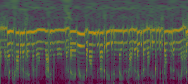

In [9]:
def generate_gradcam(model, input_image_path, target_layer_name, target_class_idx, output_path):
    """
    对给定模型和输入图像计算指定层的Grad-CAM，并将热力图叠加在原图上保存。
    - model: 已加载的 PyTorch 模型 (eval 模式)
    - input_image_path: 要分析的输入图像路径（频谱图PNG）
    - target_layer_name: 模型中目标卷积层的名称 (字符串)
    - target_class_idx: 感兴趣的类别索引（例如 PD 类别的索引）
    - output_path: 输出叠加图像的保存路径
    """
    # 确保模型在评估模式
    model.eval()

    # 读取图像并转换为张量
    img = cv2.imread(input_image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 转为RGB
    # 转换为tensor并归一化到[0,1]（假定模型期望0-1或可进一步标准化，如需要可以减均值除方差）
    img_tensor = torch.from_numpy(img).float().permute(2, 0, 1).unsqueeze(0) / 255.0

    # 确定目标层
    target_layer = dict(model.named_modules()).get(target_layer_name, None)
    if target_layer is None:
        raise ValueError(f"Layer {target_layer_name} not found in model.")
    # 用于存储前向激活和梯度
    activation = {}
    gradient = {}

    # 定义前向钩子：获取层输出
    def forward_hook(module, inp, out):
        activation[target_layer_name] = out.detach()

    # 定义反向钩子：获取层梯度
    def backward_hook(module, grad_in, grad_out):
        gradient[target_layer_name] = grad_out[0].detach()

    # 注册钩子
    hook_handle_forward = target_layer.register_forward_hook(forward_hook)
    hook_handle_backward = target_layer.register_backward_hook(backward_hook)

    # 前向传播获取输出
    output = model(img_tensor)
    if isinstance(output, (list, tuple)):
        output = output[0]  # 如果模型输出是tuple，取第一个
    # 取目标类别的分数
    target_score = output[0, target_class_idx]

    # 清除过往梯度并反向传播目标分数
    model.zero_grad()
    target_score.backward()

    # 获取保存的激活图和梯度
    act = activation[target_layer_name]  # shape: [1, C, H, W]
    grad = gradient[target_layer_name]   # shape: [1, C, H, W]
    # 钩子用完就移除
    hook_handle_forward.remove()
    hook_handle_backward.remove()

    # 计算每个通道的权重: 对梯度的宽高平均
    weights = grad.mean(dim=(2, 3), keepdim=True)  # shape: [1, C, 1, 1]
    # 按通道加权求和激活图
    cam = (weights * act).sum(dim=1, keepdim=True)  # shape: [1, 1, H, W]
    cam = F.relu(cam)  # 通过ReLU去除负值
    cam = cam.squeeze().cpu().numpy()

    # 将cam热力图调整到与原始图像大小相同
    cam_resized = cv2.resize(cam, (img.shape[1], img.shape[0]))
    # 归一化到0-255
    cam_resized = cam_resized - cam_resized.min()
    cam_resized = cam_resized / (cam_resized.max() + 1e-8)
    cam_uint8 = (cam_resized * 255).astype(np.uint8)
    # 将热力图转为颜色叠加
    heatmap = cv2.applyColorMap(cam_uint8, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    # 将热力图与原图按一定透明度叠加
    overlay = (0.6 * img + 0.4 * heatmap).astype(np.uint8)
    cv2.imwrite(output_path, overlay)
    print(f"Grad-CAM saved: {output_path}")

# 假设已经有训练好的模型 `model`（二分类模型: 0=HC, 1=PD），加载模型权重
# 这里我们构建一个简化的示例模型结构并手动加载（实际使用时，请替换为自己的模型架构和权重路径）
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.fc = nn.Linear(32, num_classes)  # 假设经过池化后通道数是 32
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # 全局平均池化
        x = F.adaptive_avg_pool2d(x, 1).reshape(x.size(0), -1)
        x = self.fc(x)
        return x

# 加载模型（在实际情况中，用实际训练的模型和参数）
# model = torch.load("path/to/trained_model.pth")
model = SimpleCNN(num_classes=2)
model.eval()

# 示例调用 Grad-CAM：选取之前生成的某张频谱图 (如 CQT 图) 做分析
example_spec_img = cqt_img_path  # 这里使用最后处理的音频CQT图作为示例
if os.path.isfile(example_spec_img):
    # target_layer_name 根据模型而定，此处以示例模型的 'conv2' 为目标层
    generate_gradcam(model, example_spec_img, target_layer_name='conv2',
                     target_class_idx=1,  # 1代表PD类（假定）
                     output_path="figures/gradcam_activation.png")
from IPython.display import Image, display
display(Image(filename="figures/gradcam_activation.png"))


**“Spectro Ablation Experiments”**

| 位置 | 关键改动 | 作用 |
|------|----------|------|
| **`ExperimentConfig` 数据类** | 统一管理实验名、是否使用局部‑全局增强、频谱模式（multi / constantq / scalogram）、是否启用因果注意力 | 让每个消融场景一行就能定义 |
| **`SpectrogramDataset`** | 新增 `spec_mode` 过滤，单频谱/多频谱轻松切换 | 用于比较单一频谱 vs 多频谱 |
| **`GlobalLocalTransform`** | 加 `enable_aug` 开关；关闭后仅做裁剪+缩放 | 用于比较有/无局部‑全局增强 |
| **`CausalSpectroNet`** | 加 `use_causal_attention`，关闭后退化为 GAP | 用于验证因果机制贡献 |
| **实验循环** | `run_experiment(cfg, seeds)` → 返回多次独立 run 的测试集指标 | 自动算均值 ± std |
| **统计检验** | 与 baseline 做 Welch t‑test；若 *p* < 0.05 自动打印 “★” | 结果更具说服力 |
| **结果输出** | ① 终端表格（均值±std，p 值）<br>② 自动保存 `ablation_results.csv`<br>③ 可选条形图 `results_barplot.png` | 论文直接截图 / 引用 |


> 代码会依次执行：  
> 1. **Baseline**（全策略启用）  
> 2. 关闭局部‑全局增强  
> 3. 单频谱 Constant‑Q  
> 4. 单频谱 Scalogram  
> 5. 关闭因果注意力  
> 并自动生成对比表与显著性标记。


In [3]:
import os
import shutil
import re
from pathlib import Path

# 基本路径
root_dir = "Voice"
output_dir = os.path.join(root_dir, "Renamed_Files")
os.makedirs(output_dir, exist_ok=True)

# 中文字符检测
def contains_chinese(text):
    return any('\u4e00' <= ch <= '\u9fff' for ch in text)

# 处理函数
def process_files():
    for subdir, _, files in os.walk(root_dir):
        if "Output" not in subdir:
            continue
        for fname in files:
            if not contains_chinese(fname):
                continue
            fpath = os.path.join(subdir, fname)
            if not os.path.isfile(fpath):
                continue

            # 判断频谱类型
            if "_cqt" in fname:
                spectro = "cqt"
            elif "_cwt" in fname:
                spectro = "cwt"
            elif "_spec.json" in fname:
                spectro = "spec"
            else:
                continue

            # chunk编号
            chunk_match = re.search(r'chunk(\d+)', fname)
            chunk = chunk_match.group(1) if chunk_match else "xx"

            # PD / HC 推断
            label = "PD" if "PD" in subdir else "HC"

            # 源目录
            source = Path(subdir).name.replace("_Output", "")

            # 后缀
            ext = Path(fname).suffix

            # 新文件名
            new_name = f"{source}_chunk{chunk}_{spectro}_{label}{ext}"
            new_path = os.path.join(output_dir, new_name)

            shutil.copy(fpath, new_path)
            print(f"✅ {fname} → {new_name}")

if __name__ == "__main__":
    process_files()
    print("\n✅ All files processed and renamed to:", output_dir)


✅ 滨江水岸社区卫生服务站_chunk36_spec.json → China_HC_chunk36_spec_HC.json
✅ 滨江水岸社区卫生服务站 14_chunk6_spec.json → China_HC_chunk6_spec_HC.json
✅ 滨江水岸社区卫生服务站_spec.json → China_HC_chunkxx_spec_HC.json
✅ 滨江水岸社区卫生服务站 3_cqt.png → China_HC_chunkxx_cqt_HC.png
✅ 滨江水岸社区卫生服务站 2_chunk6_cqt.png → China_HC_chunk6_cqt_HC.png
✅ 滨江水岸社区卫生服务站_chunk54_cqt.png → China_HC_chunk54_cqt_HC.png
✅ 滨江水岸社区卫生服务站_chunk36_cqt.png → China_HC_chunk36_cqt_HC.png
✅ 滨江水岸社区卫生服务站 4_chunk0_spec.json → China_HC_chunk0_spec_HC.json
✅ 滨江水岸社区卫生服务站_chunk60_spec.json → China_HC_chunk60_spec_HC.json
✅ 滨江水岸社区卫生服务站_chunk24_cwt.png → China_HC_chunk24_cwt_HC.png
✅ 滨江水岸社区卫生服务站 4_chunk6_cqt.png → China_HC_chunk6_cqt_HC.png
✅ 滨江水岸社区卫生服务站 14_chunk0_cqt.png → China_HC_chunk0_cqt_HC.png
✅ 滨江水岸社区卫生服务站 14_cwt.png → China_HC_chunkxx_cwt_HC.png
✅ 滨江水岸社区卫生服务站_chunk30_spec.json → China_HC_chunk30_spec_HC.json
✅ 滨江水岸社区卫生服务站_chunk18_cqt.png → China_HC_chunk18_cqt_HC.png
✅ 滨江水岸社区卫生服务站 14_chunk0_spec.json → China_HC_chunk0_spec_HC.json
✅ 滨江水岸社区卫生服务站_chunk24_spec.j

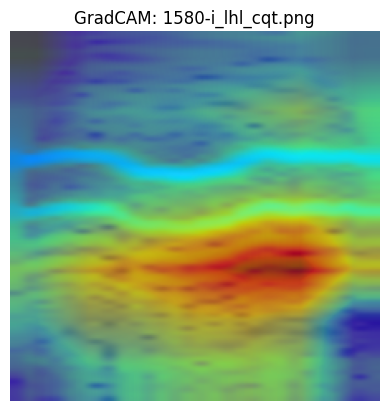

In [24]:
# ✅ GradCAM 可解释性分析 - 用于 CausalSpectroNet（ConstantQOnly 模型）
# 你需要确保 `spectro_ablation_experiments.py` 与 `.pth` 模型在当前目录

# ----------------------------
# Cell 1: 导入模块与模型结构
# ----------------------------
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image
import os

from spectro_ablation_experiments import CausalSpectroNet

# ----------------------------
# Cell 2: 定义 GradCAM 类
# ----------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if isinstance(output, tuple):
            output = output[0]  # 兼容返回 (logits, att) 的情况
        if class_idx is None:
            class_idx = output.argmax().item()
        loss = output[0, class_idx]
        self.model.zero_grad()
        loss.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = F.relu((weights * self.activations).sum(dim=1, keepdim=True))
        cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        return cam.squeeze().cpu().numpy()

# ----------------------------
# Cell 3: 加载模型 & 设置目标层
# ----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model_path = "saved_models/ConstantQOnly_seed0.pth"
model = CausalSpectroNet().to(DEVICE)
model.load_state_dict(torch.load(model_path, map_location=DEVICE))
model.eval()

# GradCAM 目标层为最后一组卷积模块
target_layer = model.features[7]  # 或者 dict([*model.features.named_modules()])["7"]
cam_generator = GradCAM(model, target_layer)

# ----------------------------
# Cell 4: 图像预处理函数与 GradCAM 可视化
# ----------------------------
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def visualize_gradcam(img_path):
    img = Image.open(img_path).convert("RGB")
    input_tensor = preprocess(img).unsqueeze(0).to(DEVICE)
    cam = cam_generator.generate(input_tensor)
    cam = (cam - cam.min()) / (cam.max() - cam.min())

    plt.imshow(img.resize((224, 224)))
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title(f"GradCAM: {os.path.basename(img_path)}")
    plt.show()

# ----------------------------
# Cell 5: 测试一张图像路径
# ----------------------------
img_path = "/Users/beibeiliu/Downloads/4.20/Parkinson/Voice/German_PD_Output/1580-i_lhl_cqt.png" # 替换为你自己的路径
visualize_gradcam(img_path)

In [24]:
# ✅ GradCAM 可解释性分析 - 用于 CausalSpectroNet（ConstantQOnly 模型）
# 你需要确保 `spectro_ablation_experiments.py` 与 `.pth` 模型在当前目录

# ----------------------------
# Cell 1: 导入模块与模型结构
# ----------------------------
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image
import os
import glob
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from sklearn.cluster import KMeans

from spectro_ablation_experiments import CausalSpectroNet

# ----------------------------
# Cell 2: 定义 GradCAM 类
# ----------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if isinstance(output, tuple):
            output = output[0]
        if class_idx is None:
            class_idx = output.argmax().item()
        loss = output[0, class_idx]
        self.model.zero_grad()
        loss.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = F.relu((weights * self.activations).sum(dim=1, keepdim=True))
        cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        return cam.squeeze().cpu().numpy()

# ----------------------------
# Cell 3: 加载模型 & 设置目标层
# ----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model_path = "saved_models/ConstantQOnly_seed0.pth"
model = CausalSpectroNet().to(DEVICE)
model.load_state_dict(torch.load(model_path, map_location=DEVICE))
model.eval()

target_layer = model.features[7]
cam_generator = GradCAM(model, target_layer)

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# ----------------------------
# Cell 4: 批量提取 Top-K 差异图像路径
# ----------------------------
topk_image_paths = sorted(
    glob.glob("/Users/beibeiliu/Downloads/4.20/Parkinson/Voice/**/*_Output/*_cqt.png", recursive=True)
)[:5]

print(f"🟢 Found {len(topk_image_paths)} images:")
for i, p in enumerate(topk_image_paths):
    print(f"{i+1}. {p}")

# ----------------------------
# Cell 5: Token 热力图函数
# ----------------------------
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
model_wav2vec = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base").eval()

def extract_token_heatmap(wav_path, n_clusters=50):
    import torchaudio
    wav, sr = torchaudio.load(wav_path)
    if sr != 16000:
        wav = torchaudio.transforms.Resample(sr, 16000)(wav)
    inputs = processor(wav.squeeze(), return_tensors="pt", sampling_rate=16000)
    with torch.no_grad():
        out = model_wav2vec(**inputs).last_hidden_state.squeeze(0).numpy()
    km = KMeans(n_clusters=n_clusters, random_state=0).fit(out)
    return km.labels_

# ----------------------------
# Cell 6: GradCAM + Token Overlay 可视化
# ----------------------------
def overlay_gradcam_and_token(img_path):
    img = Image.open(img_path).convert("RGB")
    input_tensor = preprocess(img).unsqueeze(0).to(DEVICE)
    cam = cam_generator.generate(input_tensor)
    cam = (cam - cam.min()) / (cam.max() - cam.min())

    # 推断相应 .wav 路径 (IDxx_xx_chunkXX 对应 IDxx_xx.wav)
    basename_prefix = os.path.basename(img_path).split("_chunk")[0]  # e.g. ID02_pd_2_0_0

    voice_root = "Voice"
    all_wav_dirs = [d for d in os.listdir(voice_root)
                    if os.path.isdir(os.path.join(voice_root, d))
                    and not d.endswith("Output")
                    and not d.endswith("Renamed_Files_Output")]

    candidates = []
    for folder in all_wav_dirs:
        candidate_path = os.path.join(voice_root, folder)
        matches = glob.glob(os.path.join(candidate_path, f"{basename_prefix}*.wav"))
        if matches:
            candidates.extend(matches)

    if not candidates:
        print(f"[WARN] Cannot find .wav for {img_path}")
        token_seq = None
    else:
        token_seq = extract_token_heatmap(candidates[0])

    # 可视化
    fig, axs = plt.subplots(2, 1, figsize=(10, 4), gridspec_kw={'height_ratios': [3, 1]})
    axs[0].imshow(img.resize((224, 224)))
    axs[0].imshow(cam, cmap='jet', alpha=0.5)
    axs[0].set_title("GradCAM Overlay")
    axs[0].axis('off')

    if token_seq is not None:
        axs[1].imshow(token_seq[np.newaxis, :], aspect='auto', cmap='tab20')
        axs[1].set_title("Token Heatmap")
        axs[1].set_yticks([])

    output_dir = "figures/gradcam_token_overlay"
    os.makedirs(output_dir, exist_ok=True)
    save_name = os.path.basename(img_path).replace(".png", "_overlay.png")
    plt.savefig(os.path.join(output_dir, save_name), dpi=300)
    plt.show()
    plt.close()


🟢 Found 5 images:
1. /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/China_HC_Output/滨江水岸社区卫生服务站 14_chunk0_cqt.png
2. /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/China_HC_Output/滨江水岸社区卫生服务站 14_chunk6_cqt.png
3. /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/China_HC_Output/滨江水岸社区卫生服务站 14_cqt.png
4. /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/China_HC_Output/滨江水岸社区卫生服务站 2_chunk0_cqt.png
5. /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/China_HC_Output/滨江水岸社区卫生服务站 2_chunk6_cqt.png


/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


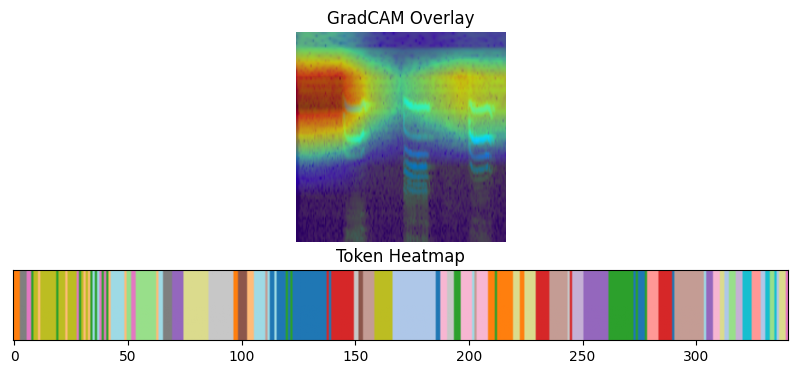

/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


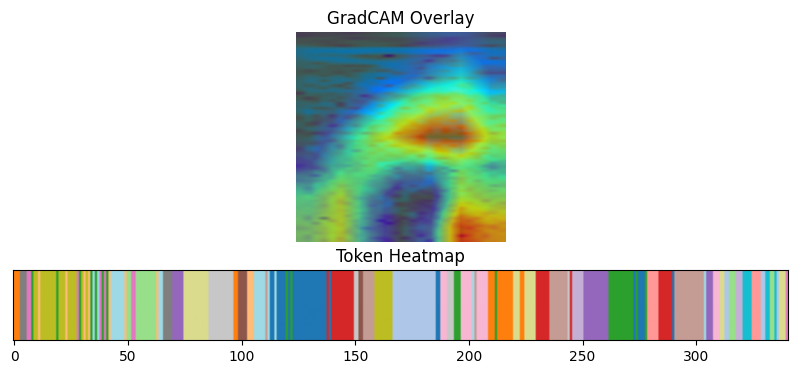

/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


[WARN] Cannot find .wav for /Users/beibeiliu/Downloads/4.20/Parkinson/Voice/China_HC_Output/滨江水岸社区卫生服务站 14_cqt.png


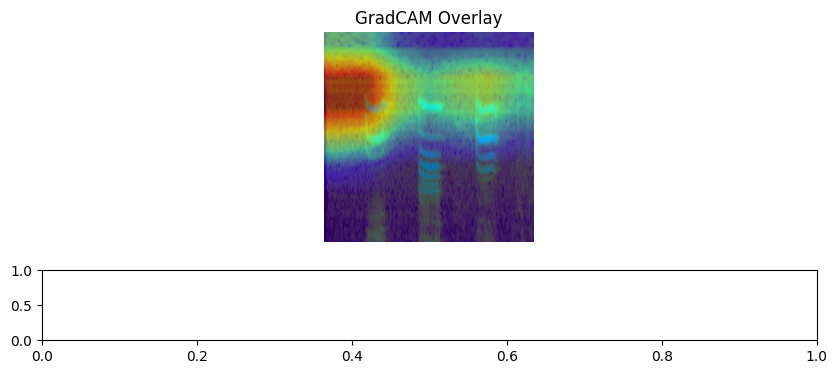

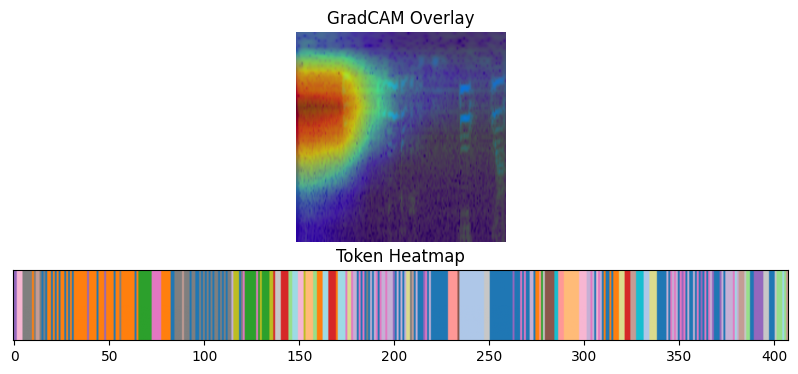

/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


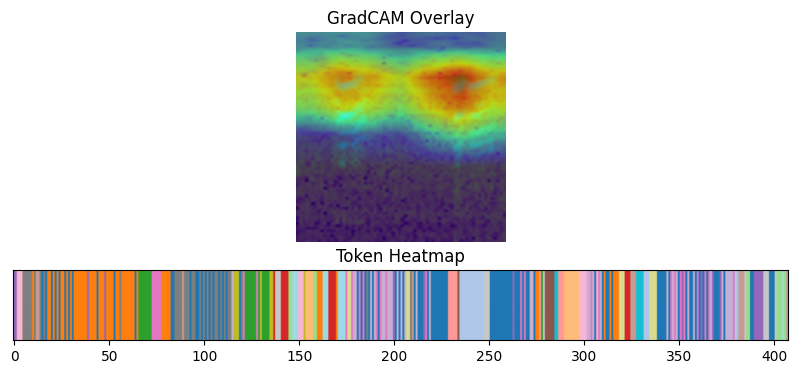

In [25]:
for path in topk_image_paths:
    overlay_gradcam_and_token(path)


[WARN] HC folder not found for: German_PD_Output

[🔥] Final Top-7 CQT Differences (dataset-matched):
#1: 111.19
  HC: Voice/KCL_Spontaneous_HC_Output/ID05_hc_0_0_0_trimmed_chunk42_cqt.png
  PD: Voice/KCL_Spontaneous_PD_Output/ID13_pd_3_2_2_chunk60_cqt.png

#2: 110.21
  HC: Voice/KCL_Spontaneous_HC_Output/ID05_hc_0_0_0_trimmed_chunk42_cqt.png
  PD: Voice/KCL_Spontaneous_PD_Output/ID13_pd_3_2_2_chunk24_cqt.png

#3: 109.81
  HC: Voice/KCL_Spontaneous_HC_Output/ID05_hc_0_0_0_trimmed_chunk42_cqt.png
  PD: Voice/KCL_Spontaneous_PD_Output/ID13_pd_3_2_2_cqt.png

#4: 108.34
  HC: Voice/KCL_Spontaneous_HC_Output/ID05_hc_0_0_0_trimmed_chunk42_cqt.png
  PD: Voice/KCL_Spontaneous_PD_Output/ID13_pd_3_2_2_chunk36_cqt.png

#5: 108.23
  HC: Voice/KCL_Spontaneous_HC_Output/ID23_hc_0_0_0_trimmed_chunk6_cqt.png
  PD: Voice/KCL_Spontaneous_PD_Output/ID13_pd_3_2_2_chunk60_cqt.png

#6: 108.01
  HC: Voice/KCL_Spontaneous_HC_Output/ID12_hc_0_0_0_trimmed_chunk12_cqt.png
  PD: Voice/KCL_Spontaneous_PD_Output/ID1

/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


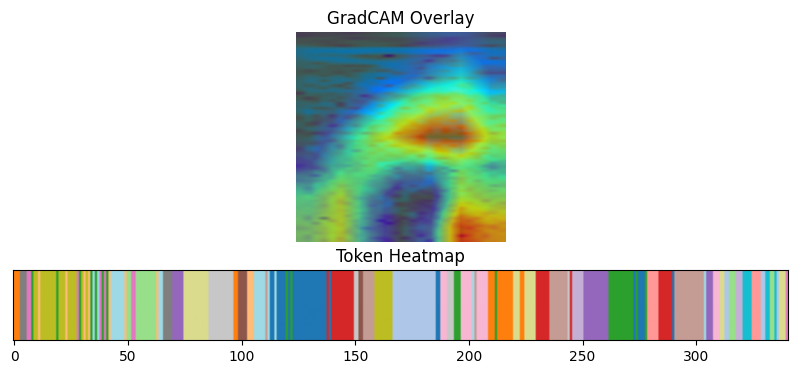

/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


[WARN] Cannot find .wav for Voice/KCL_Spontaneous_PD_Output/ID13_pd_3_2_2_cqt.png


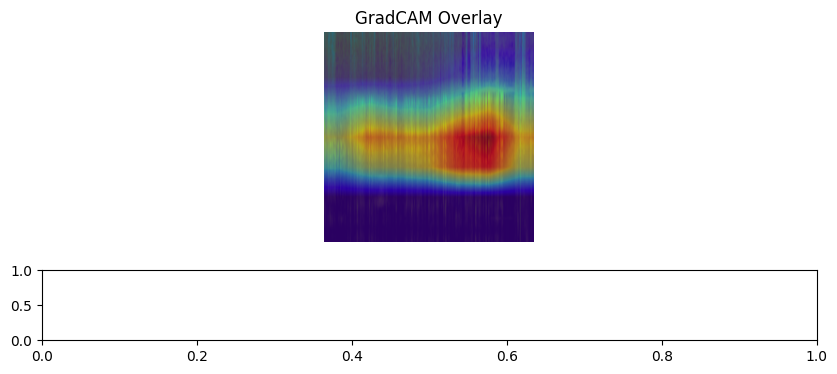

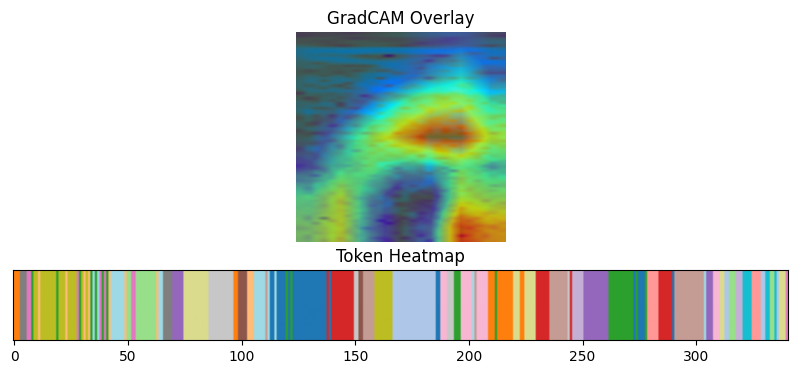

/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


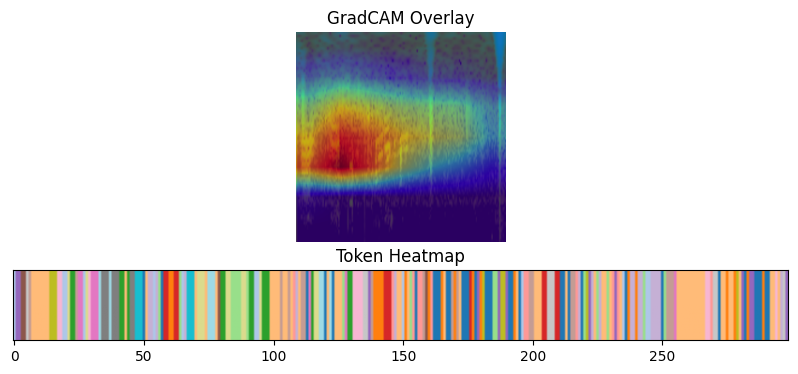

/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


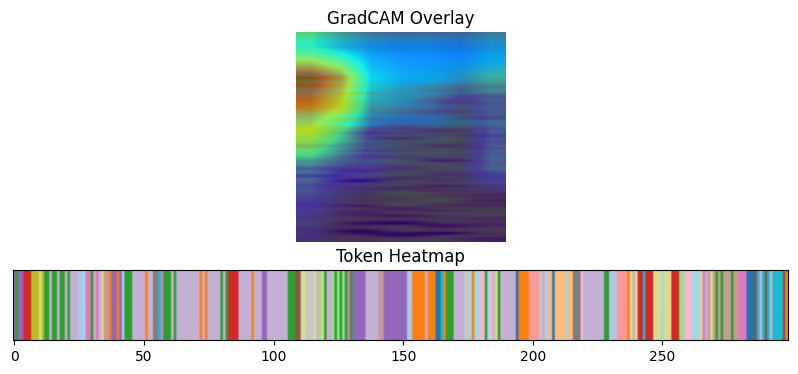

/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


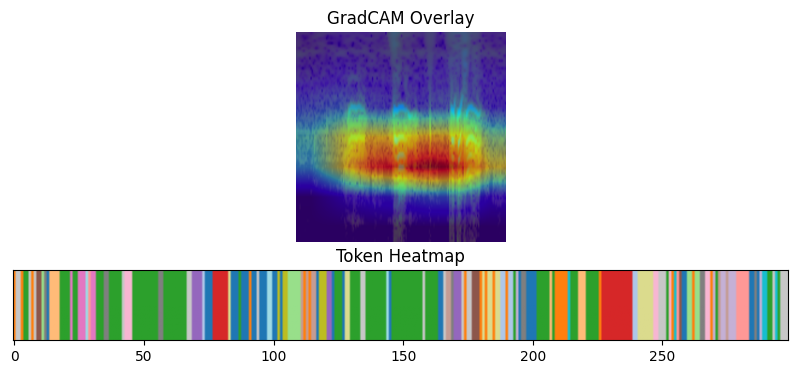

/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


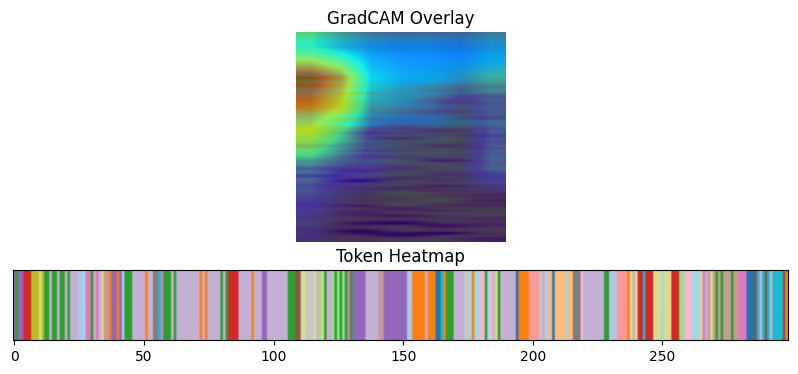

/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


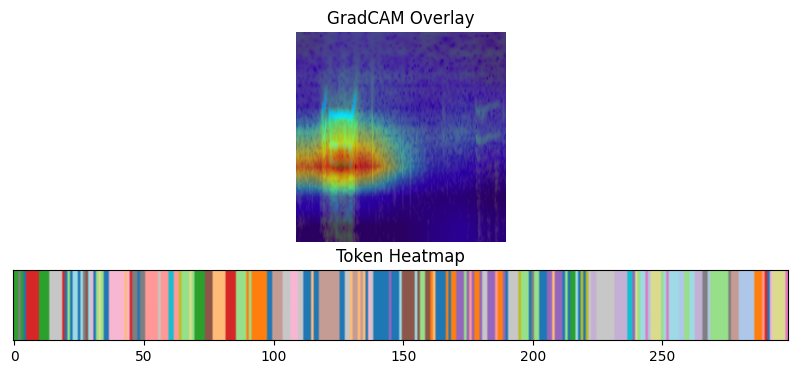

/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


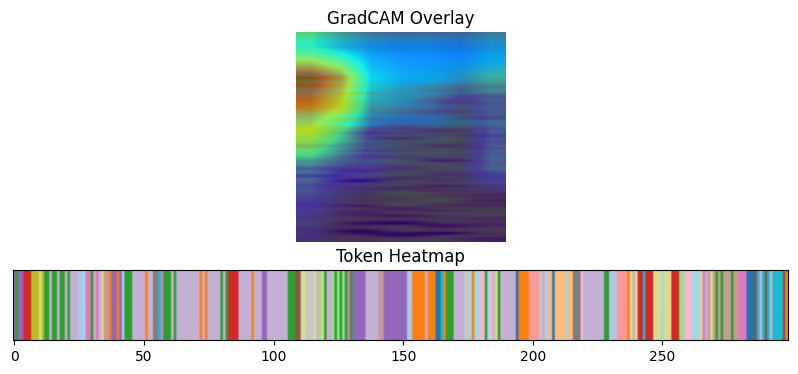

/opt/anaconda3/envs/dlnn/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


[WARN] Cannot find .wav for Voice/KCL_Spontaneous_PD_Output/ID13_pd_3_2_2_cqt.png


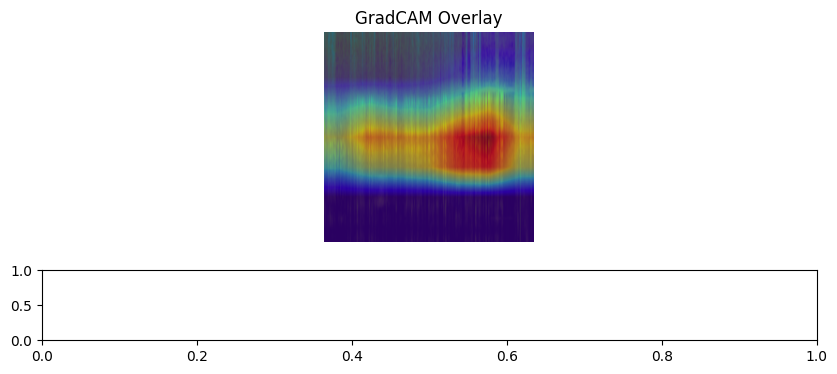

In [29]:
# ✅ GradCAM 可解释性分析 - 用于 CausalSpectroNet（ConstantQOnly 模型）
# 你需要确保 `spectro_ablation_experiments.py` 与 `.pth` 模型在当前目录

# ----------------------------
# Cell 1: 导入模块与模型结构
# ----------------------------
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image
import os
import glob
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from sklearn.cluster import KMeans
from spectro_ablation_experiments import CausalSpectroNet

# ----------------------------
# Cell 2: 定义 GradCAM 类
# ----------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if isinstance(output, tuple):
            output = output[0]
        if class_idx is None:
            class_idx = output.argmax().item()
        loss = output[0, class_idx]
        self.model.zero_grad()
        loss.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = F.relu((weights * self.activations).sum(dim=1, keepdim=True))
        cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        return cam.squeeze().cpu().numpy()

# ----------------------------
# Cell 3: 加载模型 & 设置目标层
# ----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model_path = "saved_models/ConstantQOnly_seed0.pth"
model = CausalSpectroNet().to(DEVICE)
model.load_state_dict(torch.load(model_path, map_location=DEVICE))
model.eval()

target_layer = model.features[7]
cam_generator = GradCAM(model, target_layer)

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# ----------------------------
# Cell 4: 计算 Top-K 区分差异最大的 HC vs PD 图像对
# ----------------------------
def compute_image_difference(img1_path, img2_path):
    img1 = np.array(Image.open(img1_path).resize((224, 224))).astype(np.float32) / 255.0
    img2 = np.array(Image.open(img2_path).resize((224, 224))).astype(np.float32) / 255.0
    return np.linalg.norm(img1.flatten() - img2.flatten())

def find_topk_diff_pairs(root="Voice", topk=5):
    output_dirs = [d for d in os.listdir(root) if d.endswith("Output")]
    pd_dirs = [d for d in output_dirs if "_PD_" in d]
    topk_result_all = []

    for pd_dir in pd_dirs:
        pd_path = os.path.join(root, pd_dir)
        dataset_prefix = pd_dir.replace("_PD_Output", "")
        hc_dir = f"{dataset_prefix}_HC_Output"
        hc_path = os.path.join(root, hc_dir)

        if not os.path.exists(hc_path):
            print(f"[WARN] HC folder not found for: {pd_dir}")
            continue

        pd_images = sorted(glob.glob(os.path.join(pd_path, "*_cqt.png")))
        hc_images = sorted(glob.glob(os.path.join(hc_path, "*_cqt.png")))

        local_diffs = []
        for p in pd_images:
            for h in hc_images:
                try:
                    diff = compute_image_difference(h, p)
                    local_diffs.append((diff, h, p))
                except:
                    continue

        local_diffs = sorted(local_diffs, reverse=True)[:topk]
        topk_result_all.extend(local_diffs)

    # 全局 Top-K
    topk_result_all = sorted(topk_result_all, reverse=True)[:topk]

    with open("topk_cqt_pairs_dataset_matched.txt", "w") as f:
        for d, h, p in topk_result_all:
            f.write(f"{h}|{p}\n")

    print(f"\n[🔥] Final Top-{topk} CQT Differences (dataset-matched):")
    for i, (d, h, p) in enumerate(topk_result_all):
        print(f"#{i+1}: {d:.2f}\n  HC: {h}\n  PD: {p}\n")

find_topk_diff_pairs(topk=7)

# ----------------------------
# Cell 5: 从 txt 读取 Top-K 图路
# ----------------------------
topk_image_paths = []
with open("topk_cqt_pairs.txt", "r") as f:
    for line in f:
        hc_path, pd_path = line.strip().split("|")
        topk_image_paths.extend([hc_path, pd_path])

# ----------------------------
# Cell 6: Token 热力图函数
# ----------------------------
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
model_wav2vec = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base").eval()

def extract_token_heatmap(wav_path, n_clusters=50):
    import torchaudio
    wav, sr = torchaudio.load(wav_path)
    if sr != 16000:
        wav = torchaudio.transforms.Resample(sr, 16000)(wav)
    inputs = processor(wav.squeeze(), return_tensors="pt", sampling_rate=16000)
    with torch.no_grad():
        out = model_wav2vec(**inputs).last_hidden_state.squeeze(0).numpy()
    km = KMeans(n_clusters=n_clusters, random_state=0).fit(out)
    return km.labels_

# ----------------------------
# Cell 7: GradCAM + Token Overlay 可视化
# ----------------------------
def overlay_gradcam_and_token(img_path):
    img = Image.open(img_path).convert("RGB")
    input_tensor = preprocess(img).unsqueeze(0).to(DEVICE)
    cam = cam_generator.generate(input_tensor)
    cam = (cam - cam.min()) / (cam.max() - cam.min())

    # 推断 .wav 路径
    basename_prefix = os.path.basename(img_path).split("_chunk")[0]
    voice_root = "Voice"
    all_wav_dirs = [d for d in os.listdir(voice_root)
                    if os.path.isdir(os.path.join(voice_root, d))
                    and not d.endswith("Output")
                    and not d.endswith("Renamed_Files_Output")]
    candidates = []
    for folder in all_wav_dirs:
        matches = glob.glob(os.path.join(voice_root, folder, f"{basename_prefix}*.wav"))
        if matches:
            candidates.extend(matches)

    if not candidates:
        print(f"[WARN] Cannot find .wav for {img_path}")
        token_seq = None
    else:
        token_seq = extract_token_heatmap(candidates[0])

    fig, axs = plt.subplots(2, 1, figsize=(10, 4), gridspec_kw={'height_ratios': [3, 1]})
    axs[0].imshow(img.resize((224, 224)))
    axs[0].imshow(cam, cmap='jet', alpha=0.5)
    axs[0].set_title("GradCAM Overlay")
    axs[0].axis('off')

    if token_seq is not None:
        axs[1].imshow(token_seq[np.newaxis, :], aspect='auto', cmap='tab20')
        axs[1].set_title("Token Heatmap")
        axs[1].set_yticks([])

    output_dir = "figures/gradcam_token_overlay"
    os.makedirs(output_dir, exist_ok=True)
    save_name = os.path.basename(img_path).replace(".png", "_overlay.png")
    plt.savefig(os.path.join(output_dir, save_name), dpi=300)
    plt.show()
    plt.close()

# ----------------------------
# Cell 8: 添加执行
# ----------------------------
for path in topk_image_paths:
    overlay_gradcam_and_token(path)


🎯 Top-10 KL Divergence Tokens (Symmetric):
Token 60: KL=0.00045, HC=0.0104, PD=0.0127
Token 3: KL=0.00036, HC=0.0193, PD=0.0221
Token 58: KL=0.00032, HC=0.0109, PD=0.0128
Token 51: KL=0.00028, HC=0.0121, PD=0.0140
Token 62: KL=0.00019, HC=0.0104, PD=0.0119
Token 9: KL=0.00013, HC=0.0188, PD=0.0173
Token 40: KL=0.00013, HC=0.0137, PD=0.0151
Token 13: KL=0.00012, HC=0.0191, PD=0.0176
Token 57: KL=0.00012, HC=0.0113, PD=0.0125
Token 61: KL=0.00012, HC=0.0106, PD=0.0118


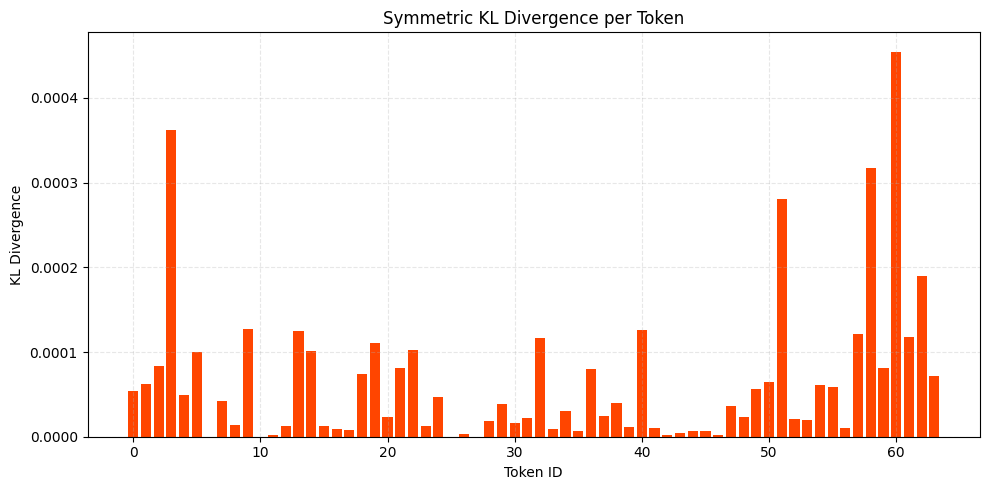

Jensen-Shannon Divergence (HC vs PD): 0.000753


In [32]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from scipy.special import rel_entr
from scipy.spatial.distance import jensenshannon

# ---------------------------
# 1. 读取并解析 CSV 中的 token 序列
# ---------------------------
csv_path = "audio_token_results.csv"  # ← 请确保路径正确
n_clusters = 64  # ← 与原先的 KMeans 聚类数一致

df = pd.read_csv(csv_path, encoding="utf-8-sig")

# 将字符串类型的 tokens 转换为 list[int]
def parse_tokens(x):
    try:
        return ast.literal_eval(x)
    except:
        return []

df["tokens_parsed"] = df["tokens"].apply(parse_tokens)

# ---------------------------
# 2. 统计 HC / PD 全局频率分布
# ---------------------------
counts_HC = np.zeros(n_clusters, dtype=int)
counts_PD = np.zeros(n_clusters, dtype=int)

for _, row in df.iterrows():
    tokens = row["tokens_parsed"]
    label = str(row["label"]).strip()
    count = np.bincount(tokens, minlength=n_clusters)
    if label in ["0", "HC"]:
        counts_HC += count
    elif label in ["1", "PD"]:
        counts_PD += count

total_HC = counts_HC.sum()
total_PD = counts_PD.sum()

# 避免除以 0
hc_freq = counts_HC / total_HC if total_HC > 0 else np.zeros_like(counts_HC)
pd_freq = counts_PD / total_PD if total_PD > 0 else np.zeros_like(counts_PD)

# 加一个微小平滑值防止 log(0)
eps = 1e-10
hc_freq += eps
pd_freq += eps
hc_freq /= hc_freq.sum()
pd_freq /= pd_freq.sum()

# ---------------------------
# 3. 计算 KL 散度（两个方向）和 JS 散度
# ---------------------------
kl_HC_PD = rel_entr(hc_freq, pd_freq)  # D_KL(P‖Q)
kl_PD_HC = rel_entr(pd_freq, hc_freq)  # D_KL(Q‖P)
kl_sym = kl_HC_PD + kl_PD_HC           # Symmetric KL
js_div = jensenshannon(hc_freq, pd_freq, base=2) ** 2  # JS divergence 是距离的平方

# 记录结果
kl_values = kl_sym
js_value = js_div

# ---------------------------
# 4. 输出 top-K KL 散度最大的 token
# ---------------------------
top_k = 10
kl_token_scores = [(i, float(kl_sym[i]), hc_freq[i], pd_freq[i]) for i in range(n_clusters)]
kl_token_scores.sort(key=lambda x: x[1], reverse=True)

print(f"🎯 Top-{top_k} KL Divergence Tokens (Symmetric):")
for tid, score, h, p in kl_token_scores[:top_k]:
    print(f"Token {tid}: KL={score:.5f}, HC={h:.4f}, PD={p:.4f}")

# ---------------------------
# 5. 可视化：KL 散度热图
# ---------------------------
plt.figure(figsize=(10, 5))
plt.bar(range(n_clusters), kl_sym, color='orangered')
plt.title("Symmetric KL Divergence per Token")
plt.xlabel("Token ID")
plt.ylabel("KL Divergence")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# ---------------------------
# 6. 可视化：JS 散度值（只有一个值）
# ---------------------------
print(f"Jensen-Shannon Divergence (HC vs PD): {js_value:.6f}")
